# Create boxes

This notebook creates spatially referenced boxes for the Weddell Sea Study sites in both raster and vector format including 25km resolution to align with the ATL20 data.

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import odc.geo.xr
from dea_tools.spatial import xr_vectorize
import matplotlib.pyplot as plt

In [2]:
with np.load('/g/data/jk72/sc0554/floes/BremenMYIfrac_ts_2019-2022_out_of_full_2019-2022.npz') as data:
    data = dict(data)
data.keys()

dict_keys(['yrange', 'si_area', 'myi_area', 'fyi_area', 'yi_area', 'amb_area', 'owt_area', 'yax', 'm_points', 'grid_area', 'lat', 'lon', 'WWS_area', 'SWS_area', 'Both_area', 'WWSnocbox', 'SWSnocbox', 'WWS_nocorner_area', 'SWS_nocorner_area', 'WWSbox', 'SWSbox', 'Bothbox', 'landmask', 'landmask_10'])

In [3]:
dim = xr.open_dataset('/g/data/gv90/sc0554/2018_2022_IceTypesUncorrected.nc')

In [4]:
# initialise boxes from Heather's numpy data
WWSnocbox = xr.DataArray(data = data['WWSnocbox'], coords=dict(y=(["y"], dim.Y.data),x=(["x"], dim.X.data)), dims = ["x", "y"]).odc.assign_crs("EPSG:3031")
SWSbox = xr.DataArray(data = data['SWSbox'], coords=dict(y=(["y"], dim.Y.data),x=(["x"], dim.X.data)), dims = ["x", "y"]).odc.assign_crs("EPSG:3031")
boxes = xr.Dataset(data_vars={'SWSbox':SWSbox,'WWSnocbox':WWSnocbox})
boxes = boxes.where(boxes==1, drop=True)

# make 25km version of boxes to match ATL20 resolution
boxes_25 = boxes.coarsen(x=2).mean().coarsen(y=2).mean()

In [16]:
# FOR SOME REASON THE VECTORIZED BOXES NEED A REVERSED AFFINE WHICH WE GET FROM THIS TIF
reverse_dim = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/data/2019_JJA_mean_MYI.tif')

In [6]:
SWSbox_gdf = xr_vectorize(da=SWSbox, transform=reverse_dim.geobox.transform, crs='EPSG:3031', mask=SWSbox.values==1)
WWSnocbox_gdf = xr_vectorize(da=WWSnocbox, transform=reverse_dim.geobox.transform,crs='EPSG:3031', mask=WWSnocbox.values==1)

In [7]:
boxes_gdf = pd.concat([SWSbox_gdf, WWSnocbox_gdf])
boxes_gdf = boxes_gdf.buffer(500000).buffer(-511000)

<AxesSubplot:>

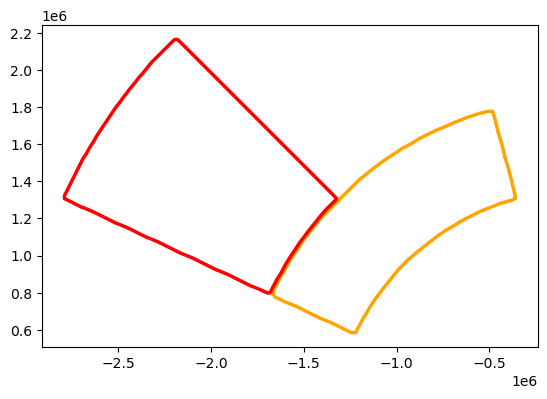

In [9]:
box_colours = ['orange','r']
boxes_gdf.boundary.plot(color=box_colours, linewidth=2.5)

<AxesSubplot:title={'center':'spatial_ref = 3031'}, xlabel='y', ylabel='x'>

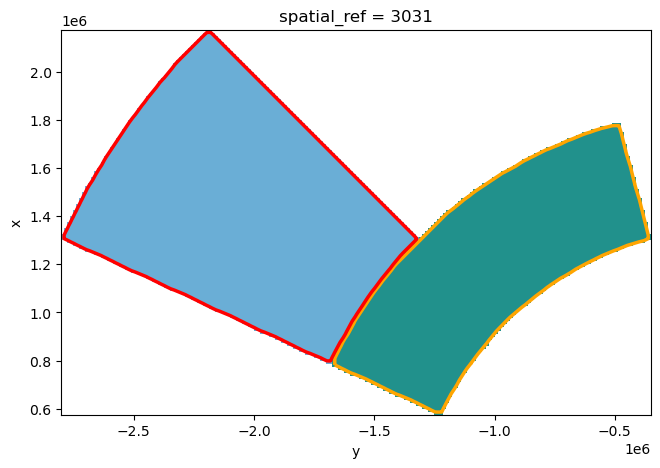

In [10]:
# Sanity check the vector and raster boxes are aligned. 

fig, ax = plt.subplots(figsize=(10,5))
boxes['SWSbox'].plot(ax=ax, add_colorbar=False)
boxes['WWSnocbox'].plot(cmap=plt.cm.Blues, ax=ax, add_colorbar=False)
boxes_gdf.boundary.plot(color=box_colours, linewidth=2.5, ax=ax)

In [11]:
boxes_gdf.to_file('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.geojson')

In [12]:
boxes.to_netcdf('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes.nc')
boxes_25.to_netcdf('/g/data/jk72/sc0554/floes/contributors/smtc/data/boxes_25km.nc')